# **Model Validation PlayGround**

In [20]:
import openai
import os
import getpass
import time
import asyncio


In [21]:
import pandas as pd
import numpy as np
import ast  # Import the ast module for literal evaluation
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', 100)
# %pip install pandarallel
import multiprocessing
num_processors = multiprocessing.cpu_count()
print(f'Available CPUs: {num_processors}')

import pandarallel
from pandarallel import pandarallel
pandarallel.initialize(nb_workers=num_processors-1, use_memory_fs=False)

Available CPUs: 8
INFO: Pandarallel will run on 7 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


-----
## Retrieval Dataframe

In [57]:
df_messages=pd.read_csv('gs://user-scripts-msca310019-capstone-49b3/data/20231019_Emails_with_Sender_Reply.csv', parse_dates=['time'])
df_messages['Sender_Receiver_Emails_list'] = df_messages['Sender_Receiver_Emails'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else [])
df_messages['num_relevant_emails'] = df_messages['Sender_Receiver_Emails_list'].apply(lambda x: len(x) if isinstance(x, list) else np.nan)
df_messages['sender']=df_messages['sender'].astype('str')
df_messages['reply_sender']=df_messages['reply_sender'].astype('str')
df_messages['sender_replier_thread'] = df_messages['sender'].str.cat(df_messages['reply_sender'], sep='-')
df_messages.head(2)

,Unnamed: 0,Email_ID,time,subject,thread,sender,recipient,message,reply_time,reply_sender,reply_recipient,reply_message,Sender_Receiver_Emails,Sender_Receiver_Emails_list,num_relevant_emails,sender_replier_thread
0,0,0,1999-06-09 04:18:00-07:00,RE: test,2,5552,[40034],How about this Friday ? Julie has not left yet. She was 2 days away from leaving to start school...,1999-06-09 08:06:00-07:00,40034,[5552],when? how are you and your family? is julie gone?,NaN,[],0,5552-40034
1,1,1,1999-06-09 08:06:00-07:00,RE: test,2,40034,[5552],when? how are you and your family? is julie gone?,1999-06-10 03:54:00-07:00,5552,[40034],Today is bad. Tommorrow I will call you.,"['Do you have lunch plans today?', ""Really? I'd feel like a mooch. Lets have lunch next week. An...","[Do you have lunch plans today?, Really? I'd feel like a mooch. Lets have lunch next week. Any d...",3,40034-5552


----
## Deduped Retrieval Dataframe ##

In [58]:
df_messages_deduped=pd.read_csv('gs://user-scripts-msca310019-capstone-49b3/data/20231026_Emails_Deduped.csv', parse_dates=['time'])
df_messages_deduped['Sender_Receiver_Emails_list'] = df_messages_deduped['Sender_Receiver_Emails'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else [])
df_messages_deduped.head(2)

,Unnamed: 0,Email_ID,time,subject,thread,sender,recipient,message,reply_time,reply_sender,reply_recipient,reply_message,Sender_Receiver_Emails,Sender_Receiver_Emails_list,sender_replier_thread
0,0,0,1999-06-09 04:18:00-07:00,RE: test,2,5552,[40034],How about this Friday ? Julie has not left yet. She was 2 days away from leaving to start school...,1999-06-09 08:06:00-07:00,40034,[5552],when? how are you and your family? is julie gone?,NaN,[],5552-40034
1,4,4,1999-06-09 08:06:00-07:00,RE: test,2,40034,[5552],when? how are you and your family? is julie gone?,1999-11-23 03:58:00-08:00,5552,[40034],Tues.is good. I'll call you.,"['Today is bad. Tommorrow I will call you.', 'Do you have lunch plans today?', ""Really? I'd feel...","[Today is bad. Tommorrow I will call you., Do you have lunch plans today?, Really? I'd feel like...",40034-5552


----
## PlayGround

In [45]:
os.environ['OPENAI_API_KEY'] = getpass.getpass('OpenAI API Key:')

if 'OPENAI_API_KEY' in os.environ:
    openai_api_key = os.environ['OPENAI_API_KEY']
    print("OpenAI API Key: is set")
else:
    print("OPENAI_API_KEY environment variable is not set.")

OpenAI API Key: ········


OpenAI API Key: is set


In [47]:
#LANGCHAIN
import langchain
from langchain.document_loaders import TextLoader
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.text_splitter import CharacterTextSplitter
from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.chains import LLMChain

#CHROMA
import chromadb
from chromadb.utils import embedding_functions
from langchain.vectorstores import Chroma

# Setting up the chroma client
chroma_client = chromadb.PersistentClient(path="vectorstores")

In [48]:
# INPUT VARIABLES 
'sender_id'
'replier_id'
'sender_email'


# PERSONALIZATION VARIABLES
num_emails= 10 #FOR RETRIEVEL + RANKING
email_retrieval_dataset=df_messages_deduped # FOR RETRIEVAL
vector_db_client=chroma_client # FOR RANKING VECTORSTORE


# TEXT GENERATION CONTROL
api_key=openai_api_key
llm_model='gpt-3.5-turbo-0301' # CAN CHANGE
llm_endpoint=ChatOpenAI(temperature=0.1, model=llm_model, openai_api_key=openai_api_key) # CAN CHANGE


# PROMPT
template_string="""Create a response to the following email {sender_email}, deriving context from these relevant emails {relevant_emails} ,using a conversation style similar to following past emails between these 2 users {prev_emails}"""


# VALIDATION VARIABLES
df_validate = df_messages_deduped
sample_size = 10


# MODEL ASSESSMENT
# %pip install rouge-score
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction


---
## BACKEND FUNCTIONS, DO NOT CHANGE

In [49]:
# Email Environment
sender_id='171'
replier_id='414'
sender_email='Where is my gift?'

In [50]:
sender_id

'171'

In [51]:
# SINGLE RESPONSE GENERATION
async def get_email_response_personalized(sender_id=sender_id,
                                    replier_id=replier_id,
                                    sender_email=sender_email,
                                    email_retrieval_dataset=df_messages_deduped,
                                    num_emails=num_emails,
                                    vector_db_client=chroma_client,
                                    api_key=openai_api_key,
                                    llm_endpoint=llm_endpoint,
                                    template_string=template_string):
    
    # First getting retrieved emails to understand conversation --------
    sender_replier_id='-'.join([sender_id, replier_id])
    previous_emails=(email_retrieval_dataset[email_retrieval_dataset.sender_replier_thread==sender_replier_id]['Sender_Receiver_Emails_list']).to_list()[0][-num_emails:]
    previous_emails
    # Second, getting ranked responses as per context ------------------
        
        # Building the Langchain vectorstore using chroma collections
    user_vector_store = Chroma(
        client=vector_db_client, 
        collection_name='user'+str(replier_id),
        embedding_function=OpenAIEmbeddings())
        # Getting ranked responses using MMR
    found_rel_emails = await user_vector_store.amax_marginal_relevance_search(sender_email, k=num_emails, fetch_k=num_emails)
    list_rel_emails=[]
    for i, doc in enumerate(found_rel_emails):
        list_rel_emails.append(doc.page_content)
    list_rel_emails
    
    
    # Setting up LangChain
    prompt_template = ChatPromptTemplate.from_template(template=template_string)    
    llm_chain=LLMChain(llm=llm_endpoint, prompt=prompt_template)
    return llm_chain.run(sender_email=sender_email, prev_emails=previous_emails, relevant_emails=list_rel_emails)
    

In [52]:
# Multiple Response Generation
async def process_all_emails(df_validate, sample_size):
    df_emails = df_validate.sample(sample_size)
    responses = []
    for index, row in df_emails.iterrows():
        response = await get_email_response_personalized(sender_id = str(row['sender']), 
                                                         replier_id= str(row['reply_sender']), 
                                                         sender_email = row['message'], 
                                                         email_retrieval_dataset=email_retrieval_dataset, 
                                                         api_key=api_key, 
                                                         vector_db_client=vector_db_client)
        responses.append(response)
        # time.sleep(20)
    df_emails['generated_reply']=responses
    return df_emails

In [53]:
# Model Performance Assessment

def calculate_scores(df_validate_out, 
                     actual_col, 
                     generated_col):
    rouge_1_scores=[]
    rouge_L_scores=[]
    bleu_scores=[]
    
    rouge_1_f1=[]
    rouge_L_f1=[]
    
    for index, row in df_validate_out.iterrows():
        
        scorer_rouge1 = rouge_scorer.RougeScorer(['rouge1'], use_stemmer=True)
        rouge_1_score=scorer_rouge1.score(row[actual_col],row[generated_col])
        rouge_1_scores.append(rouge_1_score)
        
        rouge_1_f1.append(rouge_1_score['rouge1'][2])
        
        scorer_rougeL=rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
        rouge_L_score=scorer_rougeL.score(row[actual_col],row[generated_col])
        rouge_L_scores.append(rouge_L_score)
        
        rouge_L_f1.append(rouge_L_score['rougeL'][2])

        bleu_scores.append(sentence_bleu([row[actual_col].split()], row[generated_col].split()))
    
    df_validate_out['rouge_1']=rouge_1_scores
    df_validate_out['rouge_L']=rouge_L_scores
    df_validate_out['bleu']=bleu_scores
    
    df_validate_out['rouge_1_f1']=rouge_1_f1
    df_validate_out['rouge_L_f1']=rouge_L_f1
    
    import seaborn as sns
    import matplotlib.pyplot as plt
    %config InlineBackend.figure_format = 'svg'
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    sns.histplot(data=df_validate_out, x='bleu', kde=True, ax=axes[0])
    sns.histplot(data=df_validate_out, x='rouge_1_f1', kde=True, ax=axes[1])
    sns.histplot(data=df_validate_out, x='rouge_L_f1', kde=True, ax=axes[2])

    plt.show()
    
    df_validate_out_fin=df_validate_out[[actual_col,generated_col,'rouge_1','rouge_L','bleu','rouge_1_f1','rouge_L_f1']]
    return df_validate_out_fin

## Run Tests

In [54]:
# This will take a sample of data from df_messages_deduped, and generate email replies for it

test_df= await process_all_emails(df_validate=df_messages_deduped, sample_size=10)
test_df

Retrying langchain.embeddings.openai.embed_with_retry.<locals>._embed_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for text-embedding-ada-002 in organization org-3uPIm3xy4QJopNFYHTe9obWT on requests per min. Limit: 3 / min. Please try again in 20s. Visit https://platform.openai.com/account/rate-limits to learn more. You can increase your rate limit by adding a payment method to your account at https://platform.openai.com/account/billing..


,Unnamed: 0,Email_ID,time,subject,thread,sender,recipient,message,reply_time,reply_sender,reply_recipient,reply_message,Sender_Receiver_Emails,Sender_Receiver_Emails_list,sender_replier_thread,generated_reply
2218,7213,8142,2000-11-29 03:06:00-08:00,PG&E Advice 2056-E,24585,1524,"[1535, 6306]","The purpose of this filing is to provide PG&E=01,s version of the distribut= ed=20 generation in...",2000-11-29 04:09:00-08:00,6306,[1524],"I will review the filing. The part about ""consensus positions"" concerns me= .",NaN,[],1524-6306,"Dear [Name],\n\nThank you for sending over the filing regarding PG&E's version of the distribute..."
3218,9349,10465,2000-12-05 09:30:00-08:00,Re: Electric generation,37979,4457,[5009],"A team of folks including Dari, Glen Hass, Don Vignaroli, etc have beaten these issues to death ...",2000-12-05 09:32:00-08:00,5009,[4457],Don could you send me a copy of those materials thanks,NaN,[],4457-5009,"Hi there,\n\nThanks for letting me know about the team's findings on the issues we've been discu..."
1719,5707,6235,2001-10-29 09:39:04-08:00,Send me a message,16718,1409,[441],Testing Robert Jones,2001-10-29 09:53:05-08:00,441,[1409],Hi there Sent from my BlackBerry Wireless Handheld (www.BlackBerry.net),NaN,[],1409-441,"Dear Michelle,\n\nThank you for keeping me in the loop about Carlos. It sounds like he's generat..."
6238,15731,17440,2000-11-29 06:59:00-08:00,Re: Proposed Decision,80070,162,[6655],Jeff good wrap up. May I forward to MKM and Drew?,2000-11-29 08:19:00-08:00,6655,[162],Certainly. You might also be interested to know that I spoke at length tod= ay=20 with Lad Loren...,"[""We should plan on being on the call. Since Mark is not on distribution, we should also see if ...","[We should plan on being on the call. Since Mark is not on distribution, we should also see if h...",162-6655,"Hey there,\n\nThanks for the kind words! I'm glad you thought the wrap up was good. Of course, f..."
6950,17404,19267,2001-08-15 10:29:21-07:00,RE: Can Gas Phy Basis Firm West,88498,178,[1503],Thanks for looking into this for me. Hopefully these answers help. Is this the index for all pro...,2001-08-15 13:49:26-07:00,1503,[178],"Is Empress traded in USD? Please let me know. Thanks, ML",NaN,[],178-1503,"Hi Jon,\n\nThanks for getting back to me with the answers. It looks like we will be able to offe..."
9475,23173,25669,2001-01-18 04:50:00-08:00,Re: Los Angeles Department of Water and Power,123969,13209,[1635],"These have been changed, and I sent an e mail to our Real Time desk to remind them, once again, ...",2001-01-18 07:19:00-08:00,1635,[13209],Thanks Kate Symes 01/18/2001 02:50 PM,"[""Thank you. I think if I send these emails, they eventually pick the correct CP. I hope you don...","[Thank you. I think if I send these emails, they eventually pick the correct CP. I hope you don'...",13209-1635,"Hi Kate,\n\nThanks for the update. I appreciate you reminding the Real Time desk of the correct ..."
2464,7796,8793,2001-10-25 10:31:07-07:00,RE: California Republican Party,27446,151,"[182, 1151]",His name is Sean Steele. I'll have his number pronto.,2001-10-25 10:34:37-07:00,1151,"[151, 182]",I found it already. Thanks! Ginger Dernehl Administrative Coordinator Global Government Affairs ...,"[""Jeff, Here is the int'l dial # for this call: 703 736 7385 Also, Rick knows you are on vacatio...","[Jeff, Here is the int'l dial # for this call: 703 736 7385 Also, Rick knows you are on vacation...",151-1151,"Hey Jeff,\n\nThanks for getting back to me so quickly. I appreciate it. I'm looking forward to g..."
10126,24245,26985,2001-10-19 11:55:20-07:00,RE: POWER-SS-R3C-PRC book,132821,3689,[1346],You can inactive the book on the active/inactive website. Do you also need the book's counterpar...,2001-10-19 12:39:25-07:00,1346,[3689],"On 10/18/01 the book with uploaded with MTM, delta position and gross position set to zero. The ...",NaN,[],3689-1346,"Dear Nancy,\n\nThank you for your email. Yes, I would like the book's counterparty ID t

/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

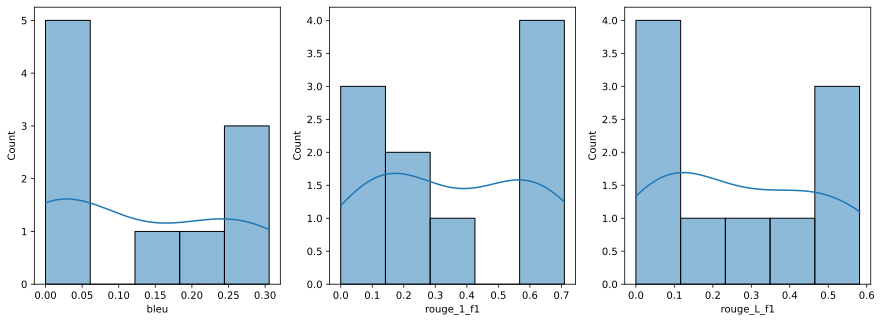

In [55]:
# This will calculate scores for the generated replies
test_df_scores=calculate_scores(df_validate_out=test_df, 
                     actual_col='message', 
                     generated_col='generated_reply')

In [56]:
test_df_scores

,message,generated_reply,rouge_1,rouge_L,bleu,rouge_1_f1,rouge_L_f1
2218,"The purpose of this filing is to provide PG&E=01,s version of the distribut= ed=20 generation in...","Dear [Name],\n\nThank you for sending over the filing regarding PG&E's version of the distribute...","{'rouge1': (0.6099290780141844, 0.6013986013986014, 0.6056338028169014)}","{'rougeL': (0.5602836879432624, 0.5524475524475524, 0.556338028169014)}",2.862156e-01,0.605634,0.556338
3218,"A team of folks including Dari, Glen Hass, Don Vignaroli, etc have beaten these issues to death ...","Hi there,\n\nThanks for letting me know about the team's findings on the issues we've been discu...","{'rouge1': (0.5076923076923077, 0.673469387755102, 0.5789473684210525)}","{'rougeL': (0.3230769230769231, 0.42857142857142855, 0.368421052631579)}",2.472628e-01,0.578947,0.368421
1719,Testing Robert Jones,"Dear Michelle,\n\nThank you for keeping me in the loop about Carlos. It sounds like he's generat...","{'rouge1': (0.0, 0.0, 0.0)}","{'rougeL': (0.0, 0.0, 0.0)}",0.000000e+00,0.000000,0.000000
6238,Jeff good wrap up. May I forward to MKM and Drew?,"Hey there,\n\nThanks for the kind words! I'm glad you thought the wrap up was good. Of course, f...","{'rouge1': (0.06802721088435375, 0.9090909090909091, 0.12658227848101267)}","{'rougeL': (0.047619047619047616, 0.6363636363636364, 0.08860759493670886)}",6.100023e-79,0.126582,0.088608
6950,Thanks for looking into this for me. Hopefully these answers help. Is this the index for all pro...,"Hi Jon,\n\nThanks for getting back to me with the answers. It looks like we will be able to offe...","{'rouge1': (0.7471910112359551, 0.6751269035532995, 0.7093333333333334)}","{'rougeL': (0.6123595505617978, 0.5532994923857868, 0.5813333333333334)}",3.055727e-01,0.709333,0.581333
9475,"These have been changed, and I sent an e mail to our Real Time desk to remind them, once again, ...","Hi Kate,\n\nThanks for the update. I appreciate you reminding the Real Time desk of the correct ...","{'rouge1': (0.09836065573770492, 0.6666666666666666, 0.1714285714285714)}","{'rougeL': (0.0546448087431694, 0.37037037037037035, 0.09523809523809523)}",2.884738e-02,0.171429,0.095238
2464,His name is Sean Steele. I'll have his number pronto.,"Hey Jeff,\n\nThanks for getting back to me so quickly. I appreciate it. I'm looking forward to g...","{'rouge1': (0.06666666666666667, 0.45454545454545453, 0.11627906976744184)}","{'rougeL': (0.04, 0.2727272727272727, 0.06976744186046512)}",7.490164e-232,0.116279,0.069767
10126,You can inactive the book on the active/inactive website. Do you also need the book's counterpar...,"Dear Nancy,\n\nThank you for your email. Yes, I would like the book's counterparty ID to be inac...","{'rouge1': (0.5428571428571428, 0.6785714285714286, 0.603174603174603)}","{'rougeL': (0.42857142857142855, 0.5357142857142857, 0.47619047619047616)}",2.157174e-01,0.603175,0.476190
3443,"I coded the King and Spalding invoices in IPAYIT yesterday. Before coding, I had to forward the ...","Dear Tonya,\n\nThank you for letting me know that you have successfully coded the King and Spald...","{'rouge1': (0.26229508196721313, 0.9142857142857143, 0.40764331210191085)}","{'rougeL': (0.21311475409836064, 0.7428571428571429, 0.33121019108280253)}",1.357796e-01,0.407643,0.331210
6718,"I have an am dr appt. Fine with me if you carry on and give me an assignment. Otherwise, it wouk...","Hey Dan,\n\nNo problem at all, I hope your doctor's appointment goes well. I can definitely carr...","{'rouge1': (0.18604651162790697, 0.43243243243243246, 0.26016260162601623)}","{'rougeL': (0.13953488372093023, 0.32432432432432434, 0.19512195121951217)}",4.729343e-02,0.260163,0.195122
